In [6]:
import numpy as np
import sys, os, shutil
import pandas as pd
import collections as cl
import itertools as it
import timeit
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Change directory
os.chdir("C:/Users/yche465/Desktop/CS570/Project")
os.getcwd()

#Import PDC dataset
PDC = np.loadtxt('PDC.txt', usecols=range(103), delimiter=",")

### Compute total time under PrEP cessation

In [8]:
#1) the number of PrEP cessations (i.e., interval where PDCs were <0.57)
Cess=PDC<4/7
Cessation=[]
for k in range(len(Cess)):
    t=0
    for i in range(102):
        if Cess[k][i]==False and Cess[k][i+1]==True:
            t+=1
    Cessation.append(t)

In [10]:
START_WEEK=[]
PSTART_WEEK=[]
END_WEEK=[]
PEND_WEEK=[]
for k in range(len(Cess)):
    start_week=[]
    pstart_week=[0]
    end_week=[]
    pend_week=[]
    for i in range(1,103):
        if Cess[k][i]==True and Cess[k][i-1]==False:
            start_week.append(i)
            pend_week.append(i)
            
        elif Cess[k][i]==False and Cess[k][i-1]==True:
            end_week.append(i)
            pstart_week.append(i)
            
    START_WEEK.append(start_week)
    PSTART_WEEK.append(pstart_week)
    END_WEEK.append(end_week)
    PEND_WEEK.append(pend_week)

import copy as cp
START_WEEK_TOT=cp.deepcopy(START_WEEK)
END_WEEK_TOT=cp.deepcopy(END_WEEK)
Pr_START_WEEK=cp.deepcopy(PSTART_WEEK)
Pr_END_WEEK=cp.deepcopy(PEND_WEEK)

for i in range(len(Cess)):
    if len(Pr_START_WEEK[i])>len(Pr_END_WEEK[i]):
        Pr_END_WEEK[i].append(103)

# make time series of start and end week
for i in range(len(Cess)):   
    if len(START_WEEK_TOT[i])>len(END_WEEK_TOT[i]):
        END_WEEK_TOT[i].append(103)
    elif len(START_WEEK_TOT[i])<len(END_WEEK_TOT[i]):
        START_WEEK_TOT[i].insert(0,0)
    elif len(START_WEEK[i])==len(END_WEEK[i]) and len(START_WEEK[i])>0 and START_WEEK[i][0]>END_WEEK[i][0]:
        START_WEEK_TOT[i].insert(0,0)
        END_WEEK_TOT[i].append(103)
    elif len(START_WEEK[i])==0 and len(START_WEEK[i])==0 and sum(Cess[i])>0:
        START_WEEK_TOT[i].insert(0,0)
        END_WEEK_TOT[i].append(103)

In [11]:
#the total duration spent in PrEP cessation
Total_Cess_Dur=np.array([sum(Cess[i]) for i in range(len(Cess))])
#the number of the number of PrEP interval
Num_PrEP=np.array([len(Pr_START_WEEK[i]) for i in range(len(Cess))])
# Time of first cessation
Cess_1st=[]
for i in range(len(START_WEEK_TOT)):
    if len(START_WEEK_TOT[i])==0:
        Cess_1st.append(104)
    else:
        Cess_1st.append(START_WEEK_TOT[i][0])

### Stage 1: K-mean clustering on 1) total cessation duration; 2) number of PrEP interval; 3) timing of the first cessation

In [14]:
from sklearn import preprocessing as prep
#Sample dataset
Data=np.dstack((Total_Cess_Dur,Num_PrEP,Cess_1st))[0]
selected= np.random.choice(len(Data),size=5000, replace=False)
sample=Data[selected]
#standardize variables
tData=np.sqrt(sample)
scaler = prep.StandardScaler().fit(tData)
scaled_data = scaler.transform(tData)
#Make into dataframe
SDATA=pd.DataFrame(scaled_data, columns = ["Cessation Time","PrEP intervals","1st Cessation"])
SDATA['ID']=selected

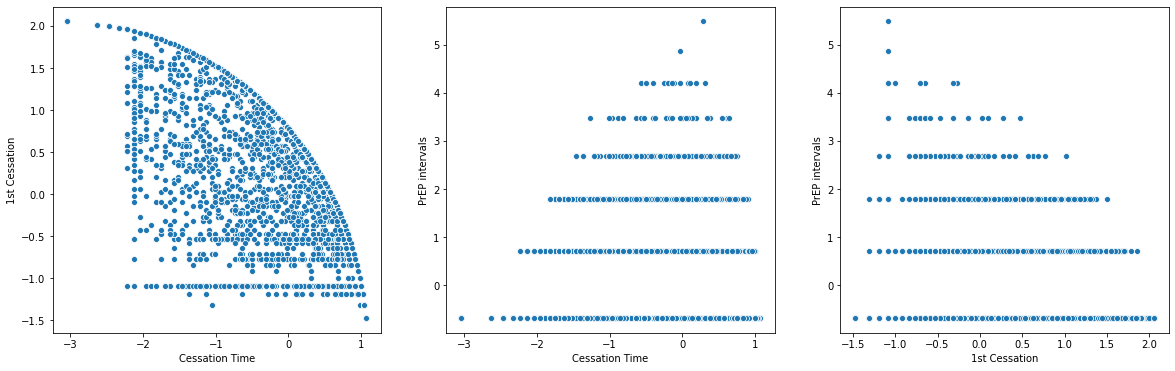

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20, 6))

sns.scatterplot(data=SDATA, x="Cessation Time", y="1st Cessation", ax=ax1)
sns.scatterplot(data=SDATA, x="Cessation Time", y="PrEP intervals", ax=ax2)
sns.scatterplot(data=SDATA, x="1st Cessation", y="PrEP intervals", ax=ax3)

In [38]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
SIL=[]
DB=[]
CAL=[]
DUNN=[]
#loop for generating cluster validation indices
for k in range(2,5):
    #k-means
    km = KMeans(n_clusters=k, random_state=0,init="k-means++").fit(scaled_data)
    cluster_labels=km.fit_predict(scaled_data)
    SDATA['Label']=km.fit_predict(scaled_data)
    #cluster validation: silhouette
    SL_avg = silhouette_score(scaled_data, cluster_labels)
    SIL.append(SL_avg)
    #cluster validation: DB
    DB_avg=davies_bouldin_score(scaled_data, cluster_labels)
    DB.append(DB_avg)
    #cluster validation: calinski
    Cal_avg=metrics.calinski_harabasz_score(scaled_data, cluster_labels)
    CAL.append(Cal_avg)

In [40]:
clusterVal=pd.DataFrame(np.array(range(2,5)),columns=["K"])
clusterVal["Silhouette Index"]=SIL
clusterVal["Davies-Bouldin index"]=DB
clusterVal["Calinski-Harabasz index"]=CAL
clusterVal

,K,Silhouette Index,Davies-Bouldin index,Calinski-Harabasz index
0,2,0.420498,1.033778,3708.287477
1,3,0.482186,0.820960,5029.660270
2,4,0.477392,0.715360,5017.794830


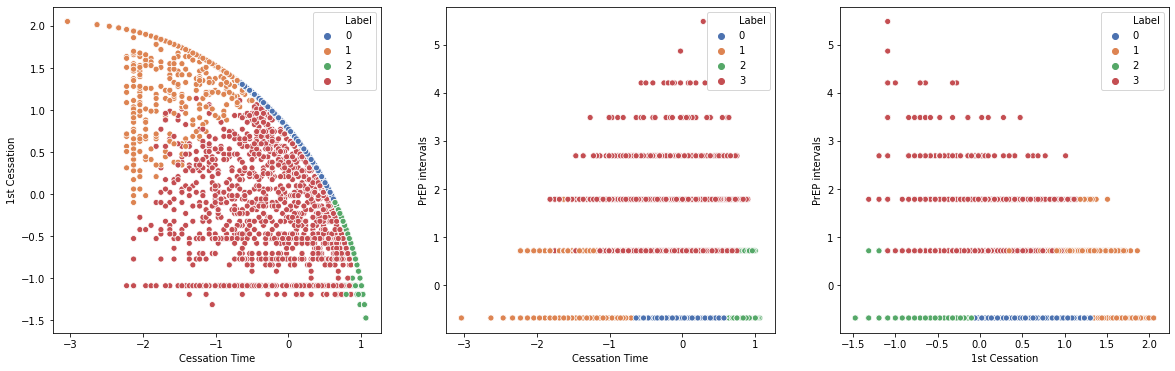

In [44]:
km = KMeans(n_clusters=4, random_state=0,init="k-means++").fit(scaled_data)
cluster_labels=km.fit_predict(scaled_data)
SDATA['Label']=km.fit_predict(scaled_data)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize=(20, 6))

sns.scatterplot(data=SDATA, x="Cessation Time", y="1st Cessation", hue="Label", palette="deep",ax=ax1)
sns.scatterplot(data=SDATA, x="Cessation Time", y="PrEP intervals", hue="Label", palette="deep", ax=ax2)
sns.scatterplot(data=SDATA, x="1st Cessation", y="PrEP intervals", hue="Label", palette="deep",ax=ax3)

In [47]:
# Within cluster distribution
PDC_samplelist=[]
for i in range(4):
    temp=PDC[SDATA[SDATA.Label==i]['ID'].values]
    PDC_samplelist.append(temp)

In [87]:
def plotstuff(j,ax):
    for i in range(len(PDC_samplelist[j])):
    #for i in range(200):
        ax.plot(Week, PDC_samplelist[j][i], "blue", linewidth=1, alpha=0.01)
    ax.set_xlabel("Follow-up Time (Weeks)",fontsize=12)
    ax.set_ylabel("PDC",fontsize=12)
    ax.text(x=0, y=1.025, s=f"Cluster {j+1}", fontsize=10, transform=ax.transAxes)

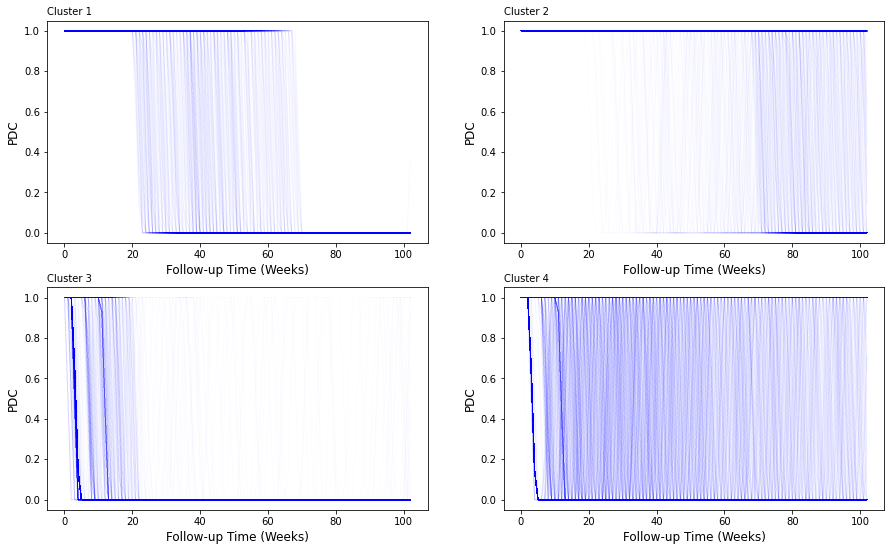

In [89]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15, 9))
Week=np.arange(0,103)

plotstuff(0,ax1)
plotstuff(1,ax2)
plotstuff(2,ax3)
plotstuff(3,ax4)

### Stage 2 Clustering: k-means clustering on DTW distance
### (Prototype: barycenter average centroid ) 

In [90]:
# time serie - dynamic time warping k-mean (baycenter average) 
from tslearn.metrics import dtw, dtw_path
from tslearn.clustering import TimeSeriesKMeans

C:\Users\yche465\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [92]:
param={"global_constraint":"sakoe_chiba", "sakoe_chiba_radius":10}

In [ ]:
PDC_samplelist

In [231]:
# Silhouette index: determine the optimal k for each stage II clustering
from tslearn.clustering import silhouette_score as tsil_index

Ts_Sil=[]
for i in range(len(PDC_samplelist)):
    #loop for generating cluster validation indices
    SIL=[]
    for k in range(2,8):
        #k-means
        model=TimeSeriesKMeans(n_clusters=k,metric="dtw", max_iter=10, max_iter_barycenter=10,metric_params=param)
        cluster_labels=model.fit_predict(PDC_samplelist[i])
        #cluster validation: silhouette
        SL_avg =tsil_index(PDC_samplelist[i], cluster_labels, metric="dtw",metric_params=param)
        SIL.append(SL_avg)
    Ts_Sil.append(SIL)

KeyboardInterrupt: 

In [238]:
i=0
#loop for generating cluster validation indices
SIL_Index0=[]
for k in range(2,8):
    #k-means
    model=TimeSeriesKMeans(n_clusters=k,metric="dtw", max_iter=10, max_iter_barycenter=10,metric_params=param)
    cluster_labels=model.fit_predict(PDC_samplelist[i])
    #cluster validation: silhouette
    SL_avg =tsil_index(PDC_samplelist[i], cluster_labels, metric="dtw",metric_params=param)
    SIL_Index0.append(SL_avg)


In [237]:
SIL_Index1

[0.5256899420890455,
 0.5194413309983111,
 0.4009657067313997,
 0.5157997802343952,
 0.6133120451289119,
 0.5740222999869294]

In [236]:
SIL_Index1=SIL.copy()

In [175]:
barycenter=[]
Label=[]
for i in range(len(PDC_samplelist)):
    model=TimeSeriesKMeans(n_clusters=3,metric="dtw", max_iter=10, max_iter_barycenter=10,metric_params=param)
    L=model.fit_predict(PDC_samplelist[i])
    Label.append(L)
    barycenter.append(model.cluster_centers_)
    

In [198]:
Cluster_PDC=[]
for j in range(len(Label)):
    Cl=[]
    for i in range(len(cl.Counter(Label[j]))):
        a=PDC_samplelist[j][Label[j]==i]
        Cl.append(a)
    Cluster_PDC.append(Cl)

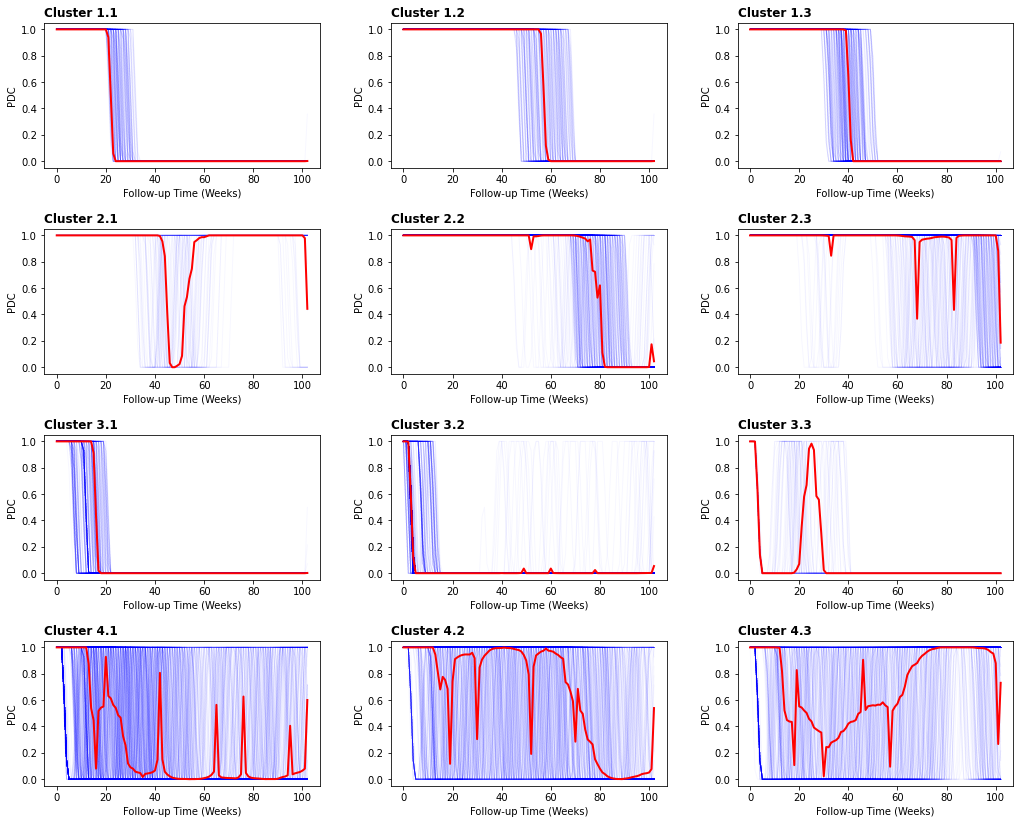

In [219]:
fig,a =  plt.subplots(4,3,figsize=(15,12))
fig.tight_layout(pad=4.0)
for k1 in range(len(Cluster_PDC)):
    for y in range(len(Cluster_PDC[k1])):
        for i in range(len(Cluster_PDC[k1][y])):
            a[k1][y].plot(Week, Cluster_PDC[k1][y][i], "blue", linewidth=1, alpha=0.03)
            a[k1][y].set_title('Cluster %d.%d' % (k1+1,y+1),loc='left',fontweight ='bold')
        a[k1][y].set_xlabel("Follow-up Time (Weeks)",fontsize=10)
        a[k1][y].set_ylabel("PDC",fontsize=10)
        a[k1][y].plot(barycenter[k1][y].ravel(), linewidth=2,color="red")
plt.show()